# Modeling Step 

### Import data + quick overview 

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("invoice_level_features.csv")

In [3]:
df.head()

,invoiceno,customerid,country,invoicemonth,totalinvoiceamount,totalitems,distinctproducts,highvaluebasket
0,536365,17850.0,United Kingdom,2010-12-01 00:00:00.000,139.12,40,7,1
1,536366,17850.0,United Kingdom,2010-12-01 00:00:00.000,22.20,12,2,0
2,536367,13047.0,United Kingdom,2010-12-01 00:00:00.000,278.73,83,12,1
3,536368,13047.0,United Kingdom,2010-12-01 00:00:00.000,70.05,15,4,0
4,536369,13047.0,United Kingdom,2010-12-01 00:00:00.000,17.85,3,1,0


In [4]:
print('shape',df.shape)

shape (19939, 8)


In [5]:
df.describe()

,customerid,totalinvoiceamount,totalitems,distinctproducts,highvaluebasket
count,18519.000000,19939.000000,19939.000000,19939.000000,19939.000000
mean,15267.677574,533.087941,279.087166,26.023271,0.862581
std,1733.645404,1781.050586,955.297671,46.990569,0.344298
min,12346.000000,0.380000,1.000000,1.000000,0.000000
25%,13777.000000,151.670000,69.000000,6.000000,1.000000
50%,15179.000000,303.300000,150.000000,15.000000,1.000000
75%,16779.000000,493.450000,296.000000,29.000000,1.000000
max,18287.000000,168469.600000,80995.000000,1110.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19939 entries, 0 to 19938
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   invoiceno           19939 non-null  object 
 1   customerid          18519 non-null  float64
 2   country             19939 non-null  object 
 3   invoicemonth        19939 non-null  object 
 4   totalinvoiceamount  19939 non-null  float64
 5   totalitems          19939 non-null  int64  
 6   distinctproducts    19939 non-null  int64  
 7   highvaluebasket     19939 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.2+ MB


missing data has to be removed 
! it's weird to find missing data at this stage since we already cleaned it with sql , but it might be the result of non strict join 

In [7]:
df= df.dropna(subset=['customerid'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18519 entries, 0 to 19937
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   invoiceno           18519 non-null  object 
 1   customerid          18519 non-null  float64
 2   country             18519 non-null  object 
 3   invoicemonth        18519 non-null  object 
 4   totalinvoiceamount  18519 non-null  float64
 5   totalitems          18519 non-null  int64  
 6   distinctproducts    18519 non-null  int64  
 7   highvaluebasket     18519 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 1.3+ MB


## Data visualization
##### goal :
explore the key relationships and distributions in the dataset toprepare for regression

In [10]:
!pip install matplotlib seaborn

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
sns.set(style='whitegrid')

<function matplotlib.pyplot.show(close=None, block=None)>

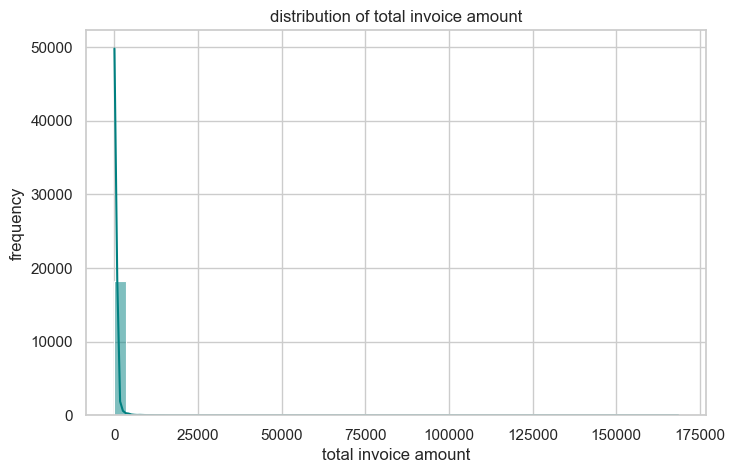

In [15]:
# distribution of the target variable
plt.figure(figsize=(8,5))
sns.histplot(df['totalinvoiceamount'],bins=50,kde=True, color='teal')
plt.title('distribution of total invoice amount')
plt.xlabel('total invoice amount')
plt.ylabel('frequency')
plt.show

##### interpretation:
- right skewed distribution (positive skew)
- the majority of invoice amounts are clustred near the lower end of the scale
- a long tail extends far to the right , these are outliers or very high purchases

!! this is very common in sales and retail datasets:
- most customers buy moderate or small baskets
- a few spend a lot causing this skew

!! these high values might disort the model if not handled correctly
 
==> solution : log transformation

In [21]:
#Transformation for Regression
import numpy as np
df['log_totalinvoiceamount'] = np.log1p(df['totalinvoiceamount'])

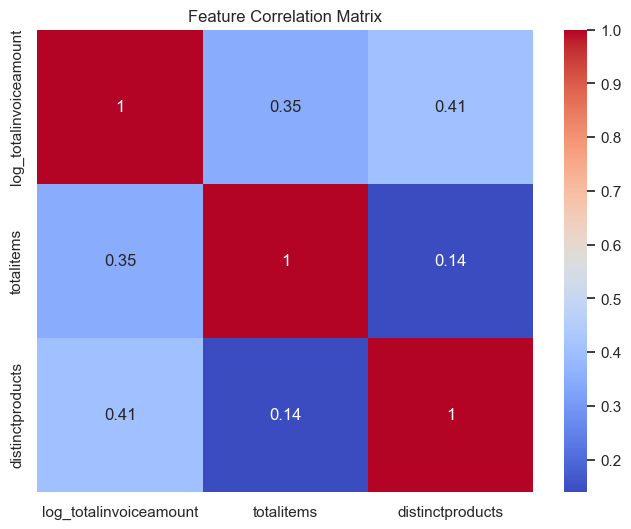

In [28]:
#Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['log_totalinvoiceamount', 'totalitems', 'distinctproducts']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

##### interpretation:
-log_totalinvoiceamount has a moderate correlation with:


   - distinctproducts(0.41): the more unique items a customer buys, the more likely the invoice total increases.

   - totalitems (0.35): similar interpretation, but the correlation is slightly weaker
  
==> there is no multicollinearity issue ==> the features are not too highly correlated with each other which is a good sign for modeling

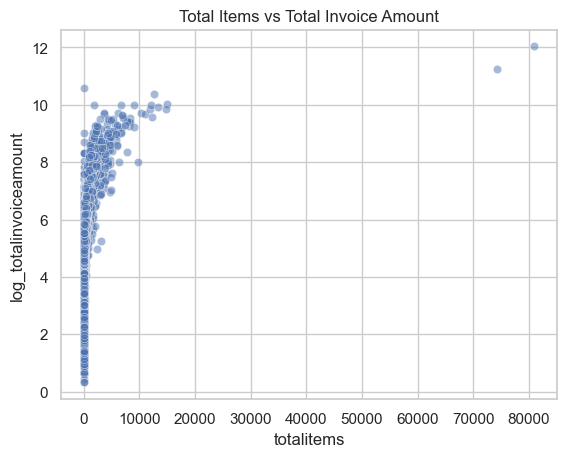

In [29]:
# relationship between Total Items vs Invoice Amount
sns.scatterplot(data=df, x='totalitems', y='log_totalinvoiceamount', alpha=0.5)
plt.title('Total Items vs Total Invoice Amount')
plt.show()

##### interpretation
- Log transformation helped reduce skewness and improve linearity, making this variable more suitable for regression modeling

- There are a few extreme values (outliers), especially beyond 20,000 items ==>we might need to investigate them later

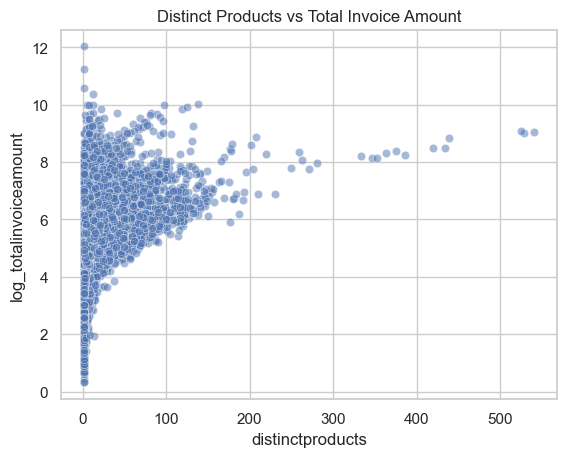

In [30]:
# relationship between Distinct Products vs Invoice Amount
sns.scatterplot(data=df, x='distinctproducts', y='log_totalinvoiceamount', alpha=0.5)
plt.title('Distinct Products vs Total Invoice Amount')
plt.show()

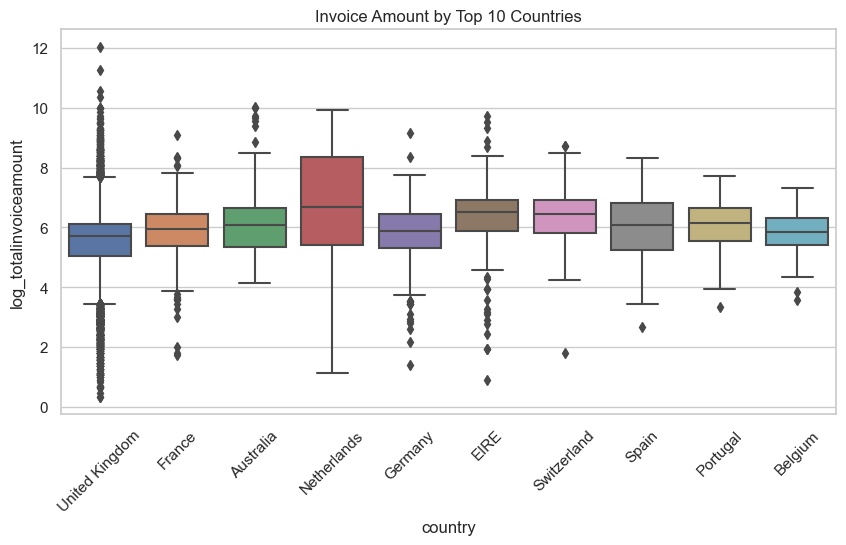

In [31]:
#Invoice Amount by Country (Top 10)
top_countries = df['country'].value_counts().head(10).index
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[df['country'].isin(top_countries)], x='country', y='log_totalinvoiceamount')
plt.title('Invoice Amount by Top 10 Countries')
plt.xticks(rotation=45)
plt.show()


##### interpretation:
- uk is the top contributer the the revenue 
- the pricing/ finance team should consider the uk as their top target 

## Regression modeling

In [32]:
# train- split the data
from sklearn.model_selection import train_test_split

# Features and target
X = df[['totalitems', 'distinctproducts']]
y = df['log_totalinvoiceamount']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

let's try linear regression

In [33]:
# train the regression model 
from sklearn.linear_model import LinearRegression

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

In [34]:
#evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R² Score:", r2)

RMSE: 0.8992305184729662
R² Score: 0.26640504294526224


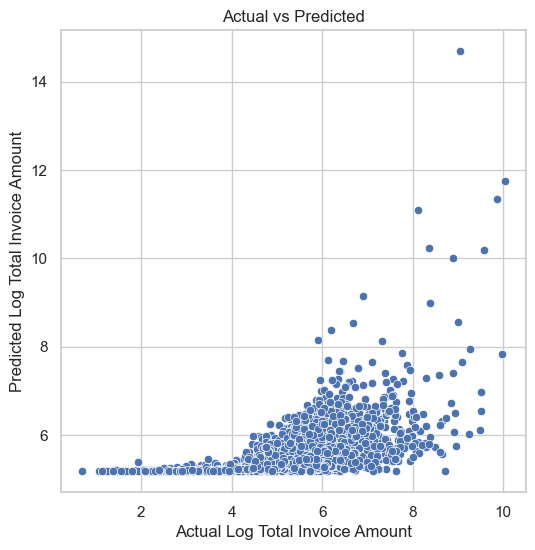

In [35]:
#actual vs predicted
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Log Total Invoice Amount")
plt.ylabel("Predicted Log Total Invoice Amount")
plt.title("Actual vs Predicted")
plt.show()


let's try random forest regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

Random Forest - MSE: 0.31, R²: 0.72


In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}")


XGBoost - MSE: 0.28, R²: 0.74


In [38]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("R2 Score:", r2_score(y_test, y_pred_tree))
print("RMSE:", mean_squared_error(y_test, y_pred_tree, squared=False))


R2 Score: 0.7487934231352285
RMSE: 0.5262091213465283


###  conclusion:

- Linear Regression: Performs the worst. It cannot capture complex patterns in the data (as expected).

- Decision Tree: Very good! But it can overfit if not tuned.

- Random Forest: Slightly behind XGBoost, still great performance and more stable.

- XGBoost: Best model so far, with the highest R² and lowest MSE